In [1]:
import argparse
import random
import numpy as np
import torch
from experiment.run import multiple_run
from utils.utils import boolean_string
import logging
import sys
from types import SimpleNamespace

In [2]:
parameters = {
    'num_runs': 1,
    'seed': 0,
    'val_size': 0.1,
    'num_val': 3,
    'num_runs_val': 3,
    'error_analysis': False,  
    'verbose': True,  
    'store': False,  
    'save_path': './',
    'imagenet_path': './imagenet1k',
    'agent': 'SUPER',
    'update': 'random',
    'retrieve': 'random',
    'second_buffer': False,  
    'update2': 'random',
    'retrieve2': 'random',
    # 'ratio': 0.2,  
    'optimizer': 'SGD',
    'learning_rate': 0.1,
    'epoch': 50,
    'batch': 128,
    'test_batch': 10000,
    'weight_decay': 0,
    'num_tasks': 20,
    'fix_order': False,  
    'plot_sample': False, 
    'data': "cifar100",
    'cl_type': "nc",
    'ns_factor': (0.0, 0.4, 0.8, 1.2, 1.6, 2.0, 2.4, 2.8, 3.2, 3.6),
    'ns_type': 'noise',
    'ns_task': (1, 1, 2, 2, 2, 2),
    'online': True, 
    'use_momentum': True,  
    'mem_size': 10000,
    'eps_mem_batch': 128,
    'sub_eps_mem_batch': 5,
    'lambda_': 100,
    'alpha': 0.9,
    'fisher_update_after': 50,
    'subsample': 50,
    'gss_mem_strength': 10,
    'gss_batch_size': 10,
    'k': 5,
    'aser_type': "asvm",
    'n_smp_cls': 2.0,
    'stm_capacity': 1000,
    'classifier_chill': 0.01,
    'log_alpha': -300,
    'minlr': 0.0005,
    'clip': 10.,
    'mem_epoch': 70,
    'labels_trick': False,  
    'separated_softmax': False,  
    'kd_trick': False, 
    'kd_trick_star': False,  
    'review_trick': False,  
    'ncm_trick': False,  
    'mem_iters': 1,
    'min_delta': 0.,
    'patience': 0,
    'cumulative_delta': False,  
    'temp': 0.07,
    'buffer_tracker': False,  
    'warmup': 4,
    'head': 'mlp',
    'exp': 'PCR',
    'Triplet': False, 
    'top5': False,  
    'mem_bank_size': 1,
    'num_subcentroids': 4,
    'PSC': False,  
    'onlyPSC': False,  
    'gamma': 0.999,
    'buffer_lip_lambda': 0.5,
    'budget_lip_lambda': 0.5,
    'headless_init_act': "relu",
    'grad_iter_step': -2,
    'lr': 0.0001,
    'optim_wd': 0.,
    'optim_mom': 0.,
    'optim_nesterov': 0,
    'ignore_other_metrics': 0,
    'debug_mode': 0,
    'reg_weight': 0.1,
    'stable_model_update_freq': 0.70,
    'stable_model_alpha': 0.999,
    'plastic_model_alpha': 0.999,
    'ucr_max': True,  
    'save_cp': False,  
    # 'cp_name': 'checkpoint.pth',
    'cp_path': './checkpoint',
}

In [3]:
import time
import numpy as np
from continuum.continuum import continuum
from continuum.data_utils import setup_test_loader
from utils.name_match import agents
from utils.setup_elements import setup_opt, setup_architecture
from utils.utils import maybe_cuda
from experiment.metrics import compute_performance, single_run_avg_end_fgt
from experiment.tune_hyperparam import tune_hyper
from types import SimpleNamespace
from utils.io import load_yaml, save_dataframe_csv, check_ram_usage
import pandas as pd
import os
import pickle
import torch
from utils.utils import maybe_cuda
import torch.nn.functional as F
import torch.nn as nn
from utils.buffer.buffer_utils import random_retrieve, get_grad_vector
import copy
from utils.buffer.buffer import Buffer, Second_Buffer


In [4]:
def load_weight(agent, checkpoint_path, params):

    checkpoint = torch.load(checkpoint_path)
    agent.model.load_state_dict(checkpoint['model_state_dict'])
    agent.opt.load_state_dict(checkpoint['optimizer_state_dict'])
    agent.params = checkpoint['params']
    agent.mem_size = checkpoint['mem_size']
    agent.eps_mem_batch = checkpoint['eps_mem_batch']
    agent.mem_iters = checkpoint['mem_iters']
    # agent.triplet = checkpoint['triplet']
    # agent.top5 = checkpoint['top5']
    # agent.buffer = Buffer(model, params)
    # agent.buffer.load_state_dict(checkpoint['buffer'])
    
    # if checkpoint['buffer2'] is not None:
    #     agent.buffer2 = Second_Buffer(agent, params)
    #     agent.buffer2.load_state_dict(checkpoint['buffer2'])
    saved_grads = checkpoint['grads']
    for name, param in agent.model.named_parameters():
        if name in saved_grads:
            param.grad = saved_grads[name]

    return agent

class Loss_change(object):
    def __init__(self, params, **kwargs):
        super().__init__()
        self.params = params
        self.subsample = params.subsample
        self.num_retrieve = params.eps_mem_batch

    def temperature_scaled_softmax(self, logits, temperature=1.0):
        """Compute the temperature-scaled softmax of a given tensor of logits.
        """
        assert temperature > 0, "Temperature must be positive."
        scaled_logits = logits / temperature
        softmax_probs = F.softmax(scaled_logits, dim=-1)
        return softmax_probs

    def calculate(self, model, sub_x, sub_y, **kwargs):
        # sub_x, sub_y = random_retrieve(buffer, self.subsample)
        grad_dims = []
        for param in model.parameters():
            grad_dims.append(param.data.numel())
        grad_vector = get_grad_vector(model.parameters, grad_dims)
        # print(grad_vector)
        # print(sub_x.shape)
        # print
        
        
        model_temp = self.get_future_step_parameters(model, grad_vector, grad_dims)
        with torch.no_grad():
            if self.params.agent == 'PCR':
                logits_pre, _ = model.pcrForward(sub_x)
                if isinstance(logits_pre, tuple):
                    logits_pre = logits_pre[1] 
                logits_post, _ = model_temp.pcrForward(sub_x)
                if isinstance(logits_post, tuple):
                    logits_post = logits_post[1]
            else:
                logits_pre = model.forward(sub_x)
                if isinstance(logits_pre, tuple):
                    logits_pre = logits_pre[1] 
                logits_post = model_temp.forward(sub_x)
                if isinstance(logits_post, tuple):
                    logits_post = logits_post[1]
            # exit(0)
            # probabilities_pre = self.temperature_scaled_softmax(logits_pre, temperature=1.2)
            
            # entropy_pre = -torch.sum(probabilities_pre * torch.log(probabilities_pre), dim=1)

            
            # probabilities_post = self.temperature_scaled_softmax(logits_post, temperature=1.2)
            # entropy_post = -torch.sum(probabilities_post * torch.log(probabilities_post), dim=1)

            flip_abs = torch.abs(logits_pre - logits_post)
            flip_sum = torch.sum(flip_abs, dim=1)
            pre_loss = F.cross_entropy(logits_pre, sub_y, reduction='none')
            post_loss = F.cross_entropy(logits_post, sub_y, reduction='none')
            scores = post_loss - pre_loss
            # big_ind = scores.sort(descending=True)[1][:self.num_retrieve]
            # big_ind = scores.sort(descending=True)[1]
            
        # return scores, big_ind, flip_sum, entropy_pre, entropy_post
        return scores, flip_sum

    def get_future_step_parameters(self, model, grad_vector, grad_dims):
        """
        computes \theta-\delta\theta
        :param this_net:
        :param grad_vector:
        :return:
        """

        new_model = copy.deepcopy(model)
        # except RuntimeError as e:
        #     new_model = model.custom_deepcopy()
        # self.overwrite_grad(new_model.parameters, grad_vector, grad_dims)
        # print(new_model)
        # for name, param in new_model.named_parameters():
        #     print(f"Parameter name: {name}")
        # exit(0)
        self.overwrite_grad(new_model.named_parameters(), grad_vector, grad_dims)
        with torch.no_grad():
            for param in new_model.parameters():
                if param.grad is not None:
                    param.data = param.data - self.params.learning_rate * param.grad.data
        return new_model

    def overwrite_grad(self, pp, new_grad, grad_dims):
        """
            This is used to overwrite the gradients with a new gradient
            vector, whenever violations occur.
            pp: parameters
            newgrad: corrected gradient
            grad_dims: list storing number of parameters at each layer
        """
        cnt = 0
        for name, param in pp:
            param.grad = torch.zeros_like(param.data)
            beg = 0 if cnt == 0 else sum(grad_dims[:cnt])
            en = sum(grad_dims[:cnt + 1])
            # print(beg, en) # 0, 540 for PCR
            # print(new_grad[beg: en].shape) # torch.Size([640000]) for ca # torch.Size([540]) for PCR
            # print(param.data.size()) # torch.Size([1000, 640]) for ca # torch.Size([20, 3, 3, 3]) for PCR
            this_grad = new_grad[beg: en].contiguous().view(
                param.data.size())
            param.grad.data.copy_(this_grad)
            cnt += 1

In [5]:
args = SimpleNamespace(**parameters)

params = args
params.cuda = torch.cuda.is_available()
np.random.seed(args.seed)
random.seed(args.seed)
torch.manual_seed(args.seed)
if params.cuda:
    torch.cuda.manual_seed(params.seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
params.trick = {'labels_trick': args.labels_trick, 'separated_softmax': args.separated_softmax,
                  'kd_trick': args.kd_trick, 'kd_trick_star': args.kd_trick_star, 'review_trick': args.review_trick,
                  'ncm_trick': args.ncm_trick}

start = time.time()
print('Setting up data stream')
data_continuum = continuum(params.data, params.cl_type, params)
data_end = time.time()
print('data setup time: {}'.format(data_end - start))
accuracy_list = []
params_keep = []
data_continuum.new_run()

# params2 = copy.deepcopy(params)
# params2.mem_size = 5000
# params2.second_buffer = True

model = setup_architecture(params)
# model2 = setup_architecture(params2)
model = maybe_cuda(model, params.cuda)
# model2 = maybe_cuda(model2, params.cuda)
opt = setup_opt(params.optimizer, model, params.learning_rate, params.weight_decay)
agent1 = agents[params.agent](model, opt, params)
# agent2 = agents[params.agent](model2, opt, param

Setting up data stream
Files already downloaded and verified
Files already downloaded and verified
data setup time: 1.1911189556121826
Task: 0, Labels:[26, 86, 2, 55, 75]
Task: 1, Labels:[93, 16, 73, 54, 95]
Task: 2, Labels:[53, 92, 78, 13, 7]
Task: 3, Labels:[30, 22, 24, 33, 8]
Task: 4, Labels:[43, 62, 3, 71, 45]
Task: 5, Labels:[48, 6, 99, 82, 76]
Task: 6, Labels:[60, 80, 90, 68, 51]
Task: 7, Labels:[27, 18, 56, 63, 74]
Task: 8, Labels:[1, 61, 42, 41, 4]
Task: 9, Labels:[15, 17, 40, 38, 5]
Task: 10, Labels:[91, 59, 0, 34, 28]
Task: 11, Labels:[50, 11, 35, 23, 52]
Task: 12, Labels:[10, 31, 66, 57, 79]
Task: 13, Labels:[85, 32, 84, 14, 89]
Task: 14, Labels:[19, 29, 49, 97, 98]
Task: 15, Labels:[69, 20, 94, 72, 77]
Task: 16, Labels:[25, 37, 81, 46, 39]
Task: 17, Labels:[65, 58, 12, 88, 70]
Task: 18, Labels:[87, 36, 21, 83, 9]
Task: 19, Labels:[96, 67, 64, 47, 44]
buffer has 10000 slots


In [8]:
checkpoint1_path = f'./checkpoint/SUPER_batch128_random_checkpoint_run0_batch2_epoch49.pth'
agent_1buffer = load_weight(agent1, checkpoint1_path, params)
test_loaders = setup_test_loader(data_continuum.test_data(), params)

In [9]:
len(test_loaders)

20

In [10]:
from utils.utils import maybe_cuda, AverageMeter
def evaluate(model, test_loaders):
    model.eval()
    acc_array = np.zeros(len(test_loaders))
    with torch.no_grad():
        for task, test_loader in enumerate(test_loaders):
            acc = AverageMeter()
            for i, (batch_x, batch_y) in enumerate(test_loader):
                batch_x = maybe_cuda(batch_x, self.cuda)
                batch_y = maybe_cuda(batch_y, self.cuda)

                logits = self.model.forward(batch_x, task)
                _, pred_label = torch.max(logits, 1)
                correct_cnt = (pred_label == batch_y).sum().item() / batch_y.size(0)

In [11]:
agent_1buffer.model.eval()
res2, ress = [], []
final, final_entropy = [], []
with torch.no_grad():
    for task, test_loader in enumerate(test_loaders[0:3]):
        res2, ress = [], []
        for t in np.arange(0.1,1,0.1):
            for i, (batch_x, batch_y) in enumerate(test_loader):
                batch_x = maybe_cuda(batch_x, torch.cuda.is_available())
                batch_y = maybe_cuda(batch_y, torch.cuda.is_available())
                out_class = agent_1buffer.model(batch_x, task, [1-t,t,0])
                
                logsm_class = F.log_softmax(out_class, 1)
                sm_class = F.softmax(out_class, 1)
        
                entropy = (-sm_class*logsm_class).sum(1).cpu()
        
                m = out_class.max(1).values.cpu().numpy()
                # print(m.shape)
                res2.append(m)
                ress.append(entropy)
        print(np.vstack(res2).shape)
        print(np.vstack(res2).argmax(0).shape)
        print(np.vstack(ress).shape)
        print(np.vstack(ress).argmin(0).shape)
        final.append(np.vstack(res2).argmax(0))
        final_entropy.append(np.vstack(ress).argmin(0))
            
        

(9, 500)
(500,)
(9, 500)
(500,)
(9, 500)
(500,)
(9, 500)
(500,)
(9, 500)
(500,)
(9, 500)
(500,)


In [12]:
for task, test_loader in enumerate(test_loaders[2:3]):
    for t in np.arange(0.1,1,0.1):
        for i, (batch_x, batch_y) in enumerate(test_loader):
            batch_x = maybe_cuda(batch_x, torch.cuda.is_available())
            batch_y = maybe_cuda(batch_y, torch.cuda.is_available())
            print(batch_y)
            out_class = agent_1buffer.model(batch_x, task, [1-t,t,0])
            m = out_class.max(1).values.cpu()
            # print(m)
        
    

tensor([53, 53, 92, 78, 78,  7, 78, 92, 92, 53, 53,  7, 13, 78, 92, 92, 78,  7,
         7, 92,  7,  7, 92, 78, 53,  7, 53, 78, 92,  7, 92, 13, 53, 13, 92, 78,
        53, 53, 92, 78,  7,  7, 78,  7, 53, 53, 92,  7, 53, 92, 92, 13, 53, 92,
        78, 13, 92,  7, 53, 53, 53, 13, 78, 13, 13, 53,  7, 78, 78, 92,  7, 78,
        53, 53, 92, 53, 92, 13,  7, 53, 53, 78, 53,  7,  7,  7, 53, 53,  7, 53,
        92, 92, 92,  7, 53, 53, 78, 92,  7,  7,  7, 53, 92,  7, 13, 78, 53,  7,
        13, 92,  7, 92, 13, 78, 78, 53, 13,  7, 78, 53, 13, 13, 53, 92, 92, 13,
         7, 78,  7, 92, 13,  7, 13, 53, 53,  7, 53, 53, 13, 13, 53, 53, 53, 13,
        13, 78, 53,  7, 13,  7, 78, 92,  7, 78, 13, 53,  7, 92, 53, 78,  7,  7,
        92, 92, 13, 78, 92, 13,  7, 13, 53, 13,  7, 92, 92,  7, 92, 78, 13, 78,
        53,  7, 78, 13,  7, 13, 13, 53,  7, 78, 13, 13, 53,  7,  7, 78, 13,  7,
         7, 53, 53, 13, 53, 92, 78, 53, 78, 78, 78,  7, 92, 13,  7, 13, 92, 78,
        78, 78, 53, 78, 92, 78,  7,  7, 

In [13]:
agent_1buffer.evaluate(test_loaders)

[0.564 0.518 0.126 0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.   ]


array([0.564, 0.518, 0.126, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   ])

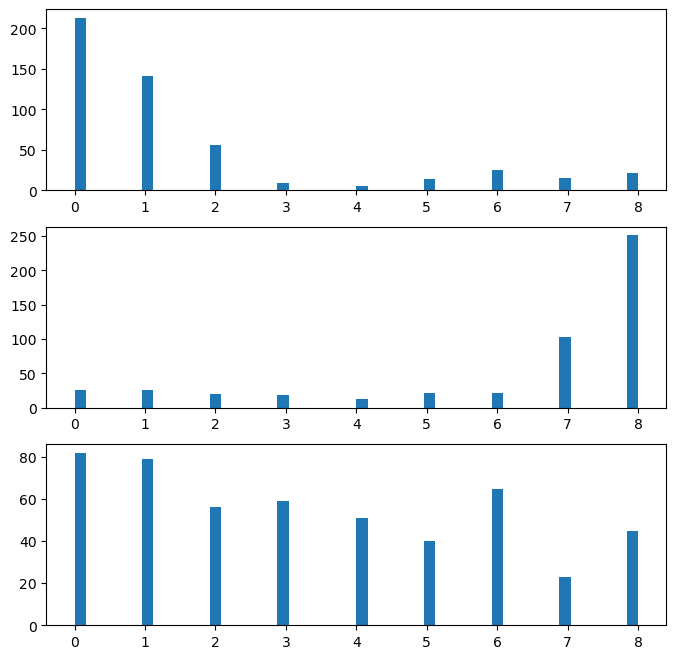

In [14]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(3,1, figsize=(8,8))
for i in range(3):
    axs[i].hist(final_entropy[i], bins=50)

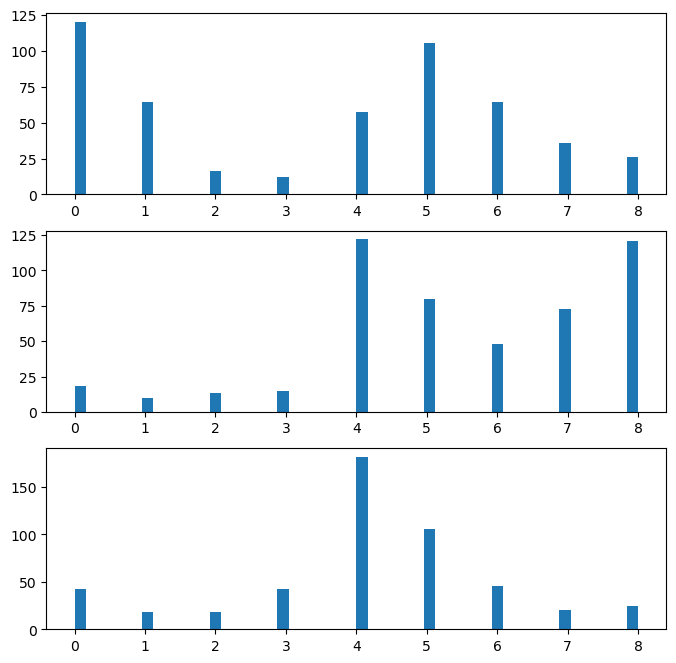

In [15]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(3,1, figsize=(8,8))
for i in range(3):
    axs[i].hist(final[i], bins=50)

In [ ]:
final